In [ ]:
from ipywidgets import IntProgress
from IPython.display import display
import time

from covid19_vulnerabilidad_mex.datos import *
from covid19_vulnerabilidad_mex.vulnerabilidad import *

import pandas as pd
import geopandas as gpd

import glob
import os
import matplotlib.pyplot as plt
from matplotlib.dates import date2num
from matplotlib.text import Text
import numpy as np
import plotly.express as px
import contextily as ctx

from datetime import timedelta
import datetime
from datetime import timedelta, date, datetime
import pickle

from sklearn.feature_selection import SelectKBest, chi2
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.cross_decomposition import PLSRegression

import seaborn as sns
import imageio
from pygifsicle import optimize

plt.style.use('ggplot')
import warnings
warnings.filterwarnings("ignore")

# Formulaciones alternativas del Índice de Vulnerabilidad

Para comparar, en este notebook vamos a construir dos formulaciones del índice:

* Basada en rankings (CDC)
* PCA

## Índice por rankings de variables

In [ ]:
variables_municipales = pd.read_csv("datos/municipios/indicadores_reclasificados.csv", dtype={"cvegeo":str})
variables_municipales

,cvegeo,nom_ent,pt_2015,an_2015,ne614_015,bi_2015,sins_15,vpt_2015,vns_2015,vna_2015,...,entidad_cvegeo,pob01,pob2020,pct_obesidad,pct_hipertension,pct_diabetes,total_camas_publicos,total_camas_privados,total_hospitales_publicos,total_hospitales_privados
0,01001,Aguascalientes,877190,2.0570,3.4786,25.6873,14.1560,0.5478,0.5543,0.6627,...,1,797010,961977,31.486541,14.942242,7.495861,0.959461,0.993091,0.981481,0.965385
1,01002,Aguascalientes,46464,4.4207,2.5959,41.8921,5.5355,1.6779,5.6457,1.2979,...,1,45492,50864,32.282284,15.320425,7.953634,0.959461,0.993091,0.981481,0.965385
2,01003,Aguascalientes,56048,4.7805,4.3906,49.1856,9.7524,1.0577,0.7756,0.9519,...,1,54136,60760,40.004293,13.751906,9.172624,0.959461,0.993091,0.981481,0.965385
3,01004,Aguascalientes,15577,4.3233,2.6265,33.0597,5.1165,1.5629,2.8986,0.5968,...,1,15042,16918,32.596450,16.431493,7.383116,0.959461,0.993091,0.981481,0.965385
4,01005,Aguascalientes,120405,3.2445,4.1297,33.7271,13.8341,0.9201,1.0273,0.9443,...,1,99590,130184,34.731715,12.356755,6.745819,0.959461,0.993091,0.981481,0.965385
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2452,32054,Zacatecas,19155,8.1332,3.6565,42.1699,8.8384,2.5438,8.9568,3.8478,...,32,18490,20177,31.075955,16.920279,9.895491,0.991437,1.000000,0.824074,0.909615
2453,32055,Zacatecas,30240,4.7985,3.4198,53.7212,13.5516,0.9201,4.8484,1.7459,...,32,29395,31804,30.526273,21.746589,12.050064,0.991437,1.000000,0.824074,0.909615
2454,32056,Zacatecas,146147,1.2432,2.1746,23.0304,14.0968,0.2485,1.2004,1.6826,...,32,138176,155533,36.822130,20.010453,11.814172,0.991437,1.000000,0.824074,0.909615
2455,32057,Zacatecas,19413,5.6122,2.5997,42.0488,9.0609,1.1950,6.9448,3.0891,...,32,16934,20285,32.477646,15.941678,8.089966,0.991437,1.000000,0.824074,0.909615


In [ ]:
variables_municipales = pd.read_csv("datos/municipios/indicadores_reclasificados.csv", dtype={"cvegeo":str})
diccionario = pd.read_csv("datos/diccionario_variables_usadas.csv").set_index('campo').drop(['tasa_cardiacas', 'tasa_pulmonares', 'tasa_diabetes', 'tasa_cancer']).reset_index()
variables = diccionario.campo.unique()
no_usadas = [v for v in variables if v.endswith('pob')]
diccionario = diccionario.set_index('campo').drop(no_usadas).reset_index()
socioeconomic_columns = diccionario[diccionario.dimension == 'Socioeconomic']['campo'].unique()
demographic_columns = diccionario[diccionario.dimension == 'Demographic']['campo'].unique()
healthcare_columns = diccionario[diccionario.dimension == 'Health Care']['campo'].unique()
housing_columns = diccionario[diccionario.dimension == 'Housing and hygiene']['campo'].unique()
epidemiological_columns = diccionario[diccionario.dimension == 'Epidemiological']['campo'].unique()
vars_socioeconomic = variables_municipales[list(socioeconomic_columns) + ['cvegeo']]
vars_demographic = variables_municipales[list(demographic_columns) + ['cvegeo']]
vars_healthcare = variables_municipales[list(healthcare_columns) + ['cvegeo']]
vars_housing = variables_municipales[list(housing_columns) + ['cvegeo']]
vars_epidemiological = variables_municipales[list(epidemiological_columns) + ['cvegeo']]

In [ ]:
vars_epidemiological["Epidemiological dimension"] = vars_epidemiological.rank(numeric_only=True, pct=True).sum(axis=1).rank(pct= True)
# vars_epidemiological.loc[(vars_epidemiological.rank(numeric_only=True, pct=True) >=.9).any(axis=1) == True, 'index_epidemiological'] = 1
# vars_epidemiological.loc[(vars_epidemiological.rank(numeric_only=True, pct=True) <.9).any(axis=1) == True, 'flag']=False
vars_epidemiological = vars_epidemiological[['Epidemiological dimension', 'cvegeo']]

vars_housing["Housing dimension"] = vars_housing.rank(numeric_only=True, pct=True).sum(axis=1).rank(pct= True)
# vars_housing.loc[(vars_housing.rank(numeric_only=True, pct=True) >=.9).any(axis=1) == True, 'index_housing'] = 1
# vars_housing.loc[(vars_housing.rank(numeric_only=True, pct=True) < .9).any(axis=1) == True, 'flag'] = False
vars_housing = vars_housing[['Housing dimension']]

vars_healthcare["Healthcare dimension"] = vars_healthcare.rank(numeric_only=True, pct=True).sum(axis=1).rank(pct= True)
# vars_healthcare.loc[(vars_healthcare.rank(numeric_only=True, pct=True) >=.9).any(axis=1) == True, 'index_healthcare'] = 1
# vars_healthcare.loc[(vars_healthcare.rank(numeric_only=True, pct=True) < .9).any(axis=1) == True, 'flag'] = False
vars_healthcare = vars_healthcare[['Healthcare dimension']]

vars_demographic["Demographic dimension"] = vars_demographic.rank(numeric_only=True, pct=True).sum(axis=1).rank(pct= True)
# vars_demographic.loc[(vars_demographic.rank(numeric_only=True, pct=True) >=.9).any(axis=1) == True, 'index_demographic'] = 1
# vars_demographic.loc[(vars_demographic.rank(numeric_only=True, pct=True) < .9).any(axis=1) == True, 'flag'] = False
vars_demographic = vars_demographic[['Demographic dimension']]

vars_socioeconomic["Socioeconomic dimension"] = vars_socioeconomic.rank(numeric_only=True, pct=True).sum(axis=1).rank(pct= True)
# vars_socioeconomic.loc[(vars_socioeconomic.rank(numeric_only=True, pct=True) >=.9).any(axis=1) == True, 'index_socioeconomic'] = 1
# vars_socioeconomic.loc[(vars_socioeconomic.rank(numeric_only=True, pct=True) < .9).any(axis=1) == True, 'flag'] = False
vars_socioeconomic = vars_socioeconomic[['Socioeconomic dimension']]

In [ ]:
svi = pd.concat([vars_epidemiological, vars_socioeconomic, vars_healthcare, vars_housing, vars_demographic], axis=1)

In [ ]:
svi['SVI Index']= svi[['Epidemiological dimension','Socioeconomic dimension', 'Healthcare dimension', 'Housing dimension','Demographic dimension']].sum(axis=1)

In [ ]:
# Sólo para referencia, guardamos una base con los índices y las variables ## NO CORRER ##
# svi_vars = svi.merge(variables_municipales)
# svi_vars.to_csv("output/svi_dimensiones")

In [ ]:
muns = gpd.read_file("datos/municipios/marco_2019.json")
svi = muns.merge(svi, left_on='municipio_cvegeo', right_on='cvegeo')
svi

,municipio_cvegeo,CVE_ENT,CVE_MUN,municipio_nombre,geometry,Epidemiological dimension,cvegeo,Socioeconomic dimension,Healthcare dimension,Housing dimension,Demographic dimension,SVI Index
0,01001,01,001,Aguascalientes,"POLYGON ((-102.09775 22.02325, -102.11598 22.0...",0.118844,01001,0.066341,0.964998,0.022385,0.994302,2.166870
1,01002,01,002,Asientos,"POLYGON ((-102.04348 22.29392, -102.05861 22.3...",0.166870,01002,0.240537,0.811152,0.288156,0.828246,2.334961
2,01003,01,003,Calvillo,"POLYGON ((-102.57625 21.96778, -102.59749 22.0...",0.381156,01003,0.310134,0.892552,0.060236,0.849410,2.493488
3,01004,01,004,Cosío,"POLYGON ((-102.26605 22.40372, -102.28993 22.4...",0.183557,01004,0.096052,0.700855,0.150997,0.562475,1.693936
4,01005,01,005,Jesús María,"POLYGON ((-102.31034 22.03716, -102.33259 22.0...",0.116402,01005,0.108669,0.968661,0.072446,0.925519,2.191697
...,...,...,...,...,...,...,...,...,...,...,...,...
2452,32054,32,054,Villa Hidalgo,"POLYGON ((-101.65599 22.51381, -101.67475 22.5...",0.386650,32054,0.382173,0.551079,0.401302,0.619862,2.341066
2453,32055,32,055,Villanueva,"POLYGON ((-102.69428 22.62230, -102.70306 22.6...",0.741758,32055,0.361823,0.945055,0.203704,0.712454,2.964794
2454,32056,32,056,Zacatecas,"POLYGON ((-102.58542 22.81149, -102.59311 22.7...",0.799349,32056,0.032967,0.874644,0.040700,0.932845,2.680505
2455,32057,32,057,Trancoso,"POLYGON ((-102.24610 22.73451, -102.24578 22.7...",0.201872,32057,0.273097,0.751323,0.347171,0.615385,2.188848


In [ ]:
svi['SVI Index']= svi[['Epidemiological dimension','Socioeconomic dimension', 'Healthcare dimension', 'Housing dimension','Demographic dimension']].sum(axis=1)

### Mapa por dimensiones

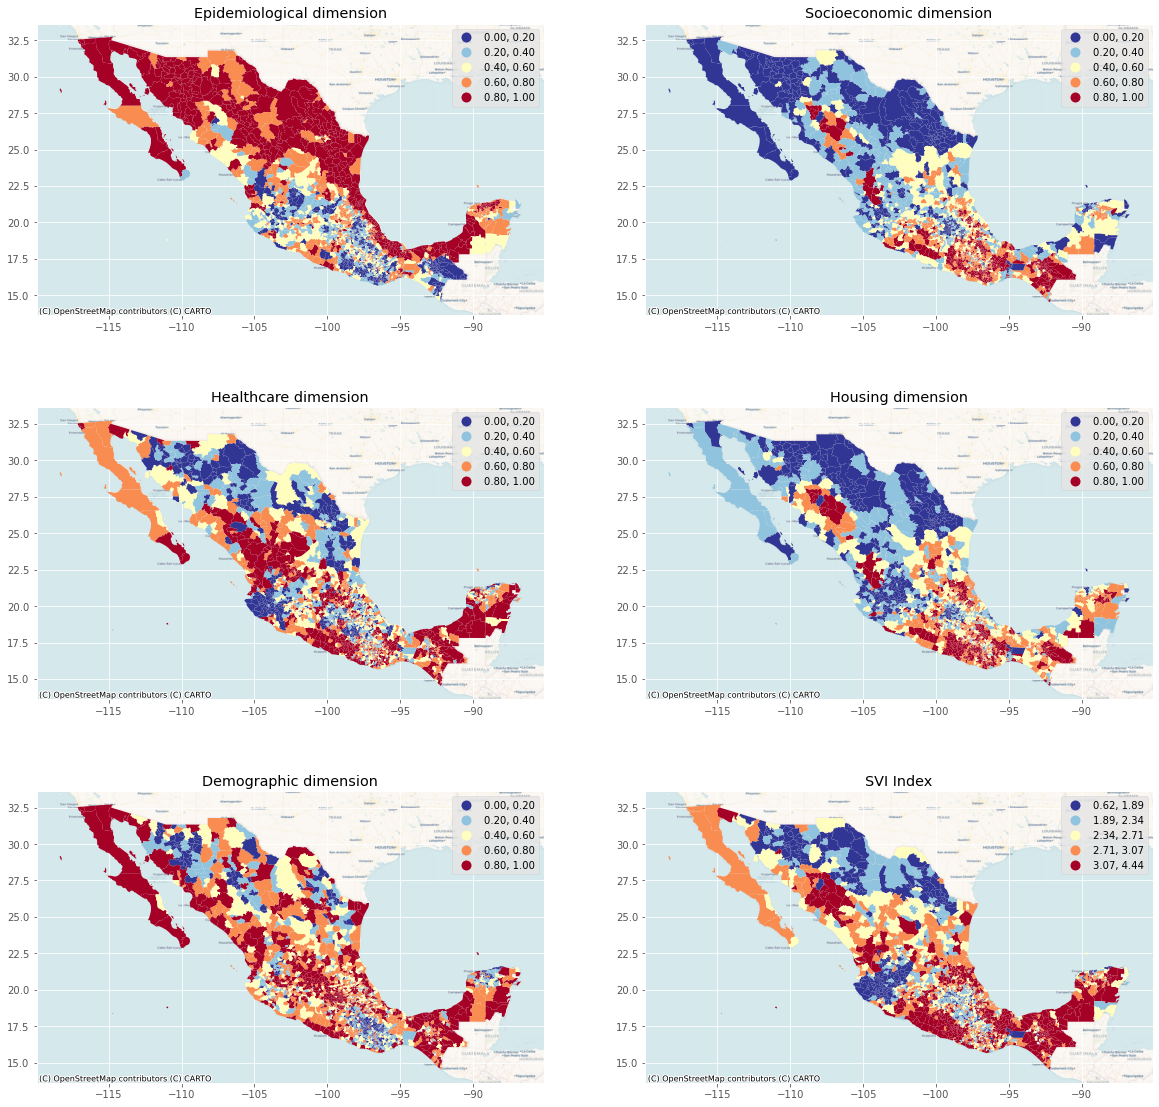

In [ ]:
columnas = ['Epidemiological dimension','Socioeconomic dimension', 'Healthcare dimension', 'Housing dimension','Demographic dimension', 'SVI Index']
fig, axes = plt.subplots(3,2,figsize=(20, 20))
axes = axes.ravel()
for i, indice in enumerate(columnas):
    f = 
    ctx.add_basemap(f, crs=svi.crs.to_string(), source=ctx.providers.CartoDB.Voyager)
    f.set_title(indice)
plt.savefig('img/svi_cdc.png')

### Mapa Índice Total

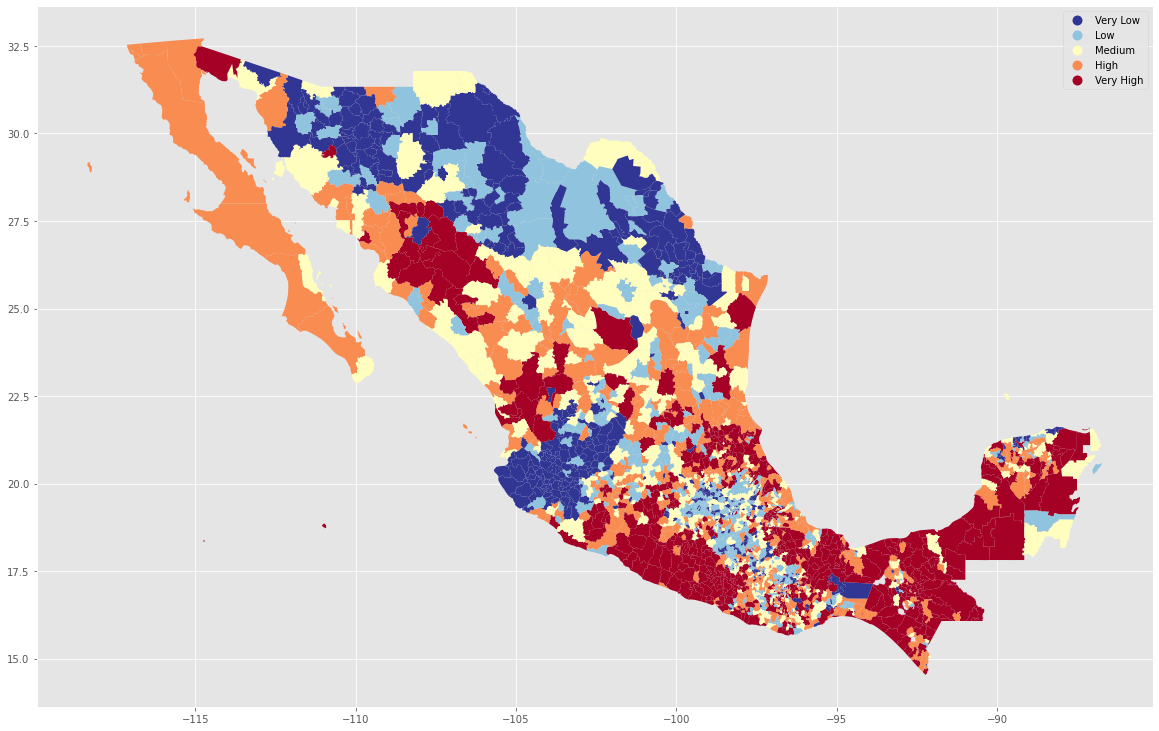

In [ ]:
_, ax = plt.subplots(figsize=(20, 20))
legend_labels=[
            'Very Low',
            'Low',
            'Medium',
            'High',
            'Very High'
]
svi.plot(column='SVI Index', scheme='Quantiles', k=5, cmap='RdYlBu_r', legend=True, ax=ax)
l = ax.get_legend()
for text, label in zip(l.get_texts(), legend_labels):
    text.set_text(label)
plt.savefig('img/svi_no_dimensions.png', bbox_inches = 'tight')

### Clasificación en grados

Para cada dimensión y para el índice total vamos a generar una columna con el grado de vulnerabilñidad (simplemente en quintil en el que está el valor correspondiente)

In [ ]:
for columna in columnas:
    svi[f'{columna} class'] = pd.qcut(svi[columna], 5, labels=[0,1,2,3,4])
svi

,municipio_cvegeo,CVE_ENT,CVE_MUN,municipio_nombre,geometry,Epidemiological dimension,cvegeo,Socioeconomic dimension,Healthcare dimension,Housing dimension,Demographic dimension,SVI Index,Epidemiological dimension class,Socioeconomic dimension class,Healthcare dimension class,Housing dimension class,Demographic dimension class,SVI Index class
0,01001,01,001,Aguascalientes,"POLYGON ((-102.09775 22.02325, -102.11598 22.0...",0.118844,01001,0.066341,0.964998,0.022385,0.994302,2.166870,0,0,4,0,4,1
1,01002,01,002,Asientos,"POLYGON ((-102.04348 22.29392, -102.05861 22.3...",0.166870,01002,0.240537,0.811152,0.288156,0.828246,2.334961,0,1,4,1,4,1
2,01003,01,003,Calvillo,"POLYGON ((-102.57625 21.96778, -102.59749 22.0...",0.381156,01003,0.310134,0.892552,0.060236,0.849410,2.493488,1,1,4,0,4,2
3,01004,01,004,Cosío,"POLYGON ((-102.26605 22.40372, -102.28993 22.4...",0.183557,01004,0.096052,0.700855,0.150997,0.562475,1.693936,0,0,3,0,2,0
4,01005,01,005,Jesús María,"POLYGON ((-102.31034 22.03716, -102.33259 22.0...",0.116402,01005,0.108669,0.968661,0.072446,0.925519,2.191697,0,0,4,0,4,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2452,32054,32,054,Villa Hidalgo,"POLYGON ((-101.65599 22.51381, -101.67475 22.5...",0.386650,32054,0.382173,0.551079,0.401302,0.619862,2.341066,1,1,2,2,3,2
2453,32055,32,055,Villanueva,"POLYGON ((-102.69428 22.62230, -102.70306 22.6...",0.741758,32055,0.361823,0.945055,0.203704,0.712454,2.964794,3,1,4,1,3,3
2454,32056,32,056,Zacatecas,"POLYGON ((-102.58542 22.81149, -102.59311 22.7...",0.799349,32056,0.032967,0.874644,0.040700,0.932845,2.680505,3,0,4,0,4,2
2455,32057,32,057,Trancoso,"POLYGON ((-102.24610 22.73451, -102.24578 22.7...",0.201872,32057,0.273097,0.751323,0.347171,0.615385,2.188848,1,1,3,1,3,1


In [ ]:
# Exportamos sólo las columnas de clases y los identificadores
clases = [c for c in svi.columns if c.endswith('class')]
identificadores = ['municipio_cvegeo', 'CVE_ENT', 'CVE_MUN', 'municipio_nombre']
columnas_exporta = identificadores + clases
exportar = svi[columnas_exporta]
exportar

,municipio_cvegeo,CVE_ENT,CVE_MUN,municipio_nombre,Epidemiological dimension class,Socioeconomic dimension class,Healthcare dimension class,Housing dimension class,Demographic dimension class,SVI Index class
0,01001,01,001,Aguascalientes,0,0,4,0,4,1
1,01002,01,002,Asientos,0,1,4,1,4,1
2,01003,01,003,Calvillo,1,1,4,0,4,2
3,01004,01,004,Cosío,0,0,3,0,2,0
4,01005,01,005,Jesús María,0,0,4,0,4,1
...,...,...,...,...,...,...,...,...,...,...
2452,32054,32,054,Villa Hidalgo,1,1,2,2,3,2
2453,32055,32,055,Villanueva,3,1,4,1,3,3
2454,32056,32,056,Zacatecas,3,0,4,0,4,2
2455,32057,32,057,Trancoso,1,1,3,1,3,1


In [ ]:
exportar.to_csv("output/svi_dimensiones.csv")

In [ ]:
pd.qcut(svi['SVI Index'], 5)

0       (1.892, 2.337]
1       (1.892, 2.337]
2       (2.337, 2.708]
3       (0.618, 1.892]
4       (1.892, 2.337]
             ...      
2452    (2.337, 2.708]
2453     (2.708, 3.07]
2454    (2.337, 2.708]
2455    (1.892, 2.337]
2456    (1.892, 2.337]
Name: SVI Index, Length: 2457, dtype: category
Categories (5, interval[float64]): [(0.618, 1.892] < (1.892, 2.337] < (2.337, 2.708] < (2.708, 3.07] < (3.07, 4.439]]

In [ ]:
diccionario.to_csv("output/diccionario_svi.csv")